# Финальный проект. Телеком

Оператор связи *«ТелеДом»* хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Ваша задача** — обучить на этих данных модель для прогноза оттока клиентов.


**Описание услуг**

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2. Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- **contract** — информация о договорах;
- **personal** — персональные данные клиентов;
- **internet** — информация об интернет-услугах;
- **phone** — информация об услугах телефонии.

**Таблица contract**
- `customerID` — ID абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Таблица personal**
- `customerID` — ID пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Таблица internet**
- `customerID` — ID пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Таблица phone**
- `customerID` — ID пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

1. [Загрузка данных](#1-загрузка-данных)
2. [Первичный EDA-анализ](#2-первичный-eda-анализ)
3. [Объединение таблиц](#3-объединение-таблиц)
4. [EDA-анализ по объединенной таблице](#4-eda-анализ-по-объединенной-таблице)
5. [Подготовка данных к обучению](#5-подготовка-данных-к-обучению)
6. [Обучение моделей и подбор гиперпараметров](#6-обучение-моделей-и-подбор-гиперпараметров)
    - [6.1. RandomForestClassifier](#61-randomforestclassifier)
    - [6.2. MLPClassifier](#62-mlpclassifier)
    - [6.3. LightGBM](#63-lightgbm)
    - [6.4. CatBoost](#64-catboost)
        - [6.4.1. Докрутим CatBoostClassifier](#641-докрутим-catboostclassifier)
        - [6.4.2. Финальная модель CatBoostClassifier](#642-финальная-модель-catboostclassifier)
7. [Тестирование и демонстрация работы](#7-тестирование-и-демонстрация-работы)
    - [7.1. Выводы](#71-выводы)
8. [Финальные выводы](#8-финальные-выводы)

## Загрузка даннных

In [ ]:
#!pip install -U numpy
#!pip install --force-reinstall --no-cache-dir catboost

In [ ]:
#!pip install lightgbm

In [ ]:
#!pip install imblearn

In [ ]:
#!pip install scikit-learn==1.2.2 --force-reinstall

In [ ]:
#!pip install --force-reinstall \
    #numpy==1.22.4 \
    #pandas==1.5.3 \
    #scikit-learn==1.2.2 \
    #imbalanced-learn==0.10.1 \
    #joblib==1.1.1 \
    #scipy==1.9.1


In [1]:
# Импорты
# Стандартные библиотеки
import os
import random
from itertools import product

# Научные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SQL и подключение к базе
from sqlalchemy import create_engine

# Предобработка и моделирование
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_val_score, RandomizedSearchCV
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

# Подбор параметров
from scipy.stats import randint, uniform

# Сохранение / загрузка
import joblib

#
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Константы
RANDOM_STATE = 260325

In [3]:
if os.path.exists("ds-plus-final.db"):
    os.remove("ds-plus-final.db")

# Скачаем
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-04-01 19:33:16--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db’

ds-plus-final.db    100%[===================>]   3.42M  --.-KB/s    in 0.07s   

2025-04-01 19:33:17 (52.3 MB/s) - ‘ds-plus-final.db’ saved [3588096/3588096]



In [4]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [5]:
# Загрузка всех таблиц
tables = ['contract', 'personal', 'internet', 'phone']
dfs = {table: pd.read_sql(f'SELECT * FROM {table}', con=engine) for table in tables}

In [6]:
# Проверка загрузки всех таблиц из словаря dfs
for name, df in dfs.items():
    print(f"{name}: shape = {df.shape}")


contract: shape = (7043, 8)
personal: shape = (7043, 5)
internet: shape = (5517, 8)
phone: shape = (6361, 2)


In [7]:
# Выводим информацию о размере и первых строках каждой таблицы
for name, df in dfs.items():
    print(f'\n Таблица: {name} — размер: {df.shape}')
    display(df.head())
    display(df.info())


 Таблица: contract — размер: (7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


None


 Таблица: personal — размер: (7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None


 Таблица: internet — размер: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


 Таблица: phone — размер: (6361, 2)


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

## Первичный EDA-анализ

**План:**

- Проверить пропуски и типы;

- Привести MonthlyCharges, TotalCharges, SeniorCitizen к нужным типам;

- Проверить, почему internet и phone меньше по размеру;

- Провести визуальный и числовой анализ распределений;

- Определить, какие признаки бинарные, категориальные, числовые;

- Выделить потенциальные аномалии.

In [8]:
# Приводим названия всех колонок к нижнему регистру и snake_case
for name, df in dfs.items():
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Приведение типов
dfs['contract']['monthlycharges'] = pd.to_numeric(dfs['contract']['monthlycharges'], errors='coerce')
dfs['contract']['totalcharges'] = pd.to_numeric(dfs['contract']['totalcharges'], errors='coerce')
dfs['personal']['seniorcitizen'] = dfs['personal']['seniorcitizen'].astype(int)

# Преобразуем 'No' в EndDate → NaN (то есть договор не расторгнут)
dfs['contract']['enddate'] = dfs['contract']['enddate'].replace('No', np.nan)

# Проверим количество пропусков
for name, df in dfs.items():
    print(f'\n{name.upper()} — пропуски:')
    display(df.isna().sum())


CONTRACT — пропуски:


customerid             0
begindate              0
enddate             5942
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges          11
dtype: int64


PERSONAL — пропуски:


customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64


INTERNET — пропуски:


customerid          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64


PHONE — пропуски:


customerid       0
multiplelines    0
dtype: int64

In [9]:
# Проверка пропусков в totalcharges
dfs['contract']['totalcharges'].isna().sum()

11

In [10]:
# Выведем пропуски
dfs['contract'][dfs['contract']['totalcharges'].isna()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,NaN,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaN,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaN,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaN,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaN,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaN,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaN,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaN,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaN,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaN,Two year,No,Mailed check,73.35,NaN


In [11]:
# Заменим пропуски на 0.0
dfs['contract']['totalcharges'] = dfs['contract']['totalcharges'].fillna(0.0)

**Обработка пропусков в `totalcharges`:**

В таблице `contract` было 11 строк с пропущенным значением в столбце `totalcharges`.  
Анализ показал, что все эти клиенты заключили договор 1 февраля 2020 года — это дата актуальности выгрузки.  
Они только подключились, поэтому ещё не успели накопить расходы.  
Значения `NaN` были логично заменены на `0.0`.

**Промежуточные выводы по первичному EDA-анализу**

**Таблица contract:**

- 5942 пропуска в enddate → значит 5942 клиента не ушли, а остальные (7043 - 5942 = 1101) — ушли.
Это и будет наша целевая переменная (is_churn).

- 11 пропусков в totalcharges — скорее всего, у новых клиентов, у которых monthlycharges > 0, но totalcharges ещё не накопились.

**Таблица personal:**

- Всё в порядке — без пропусков, признаки бинарные (yes / no), seniorcitizen — теперь int.

**Таблица internet:**

- 7043 - 5517 = 1526 клиентов не используют интернет, отсюда и отсутствие записей → при объединении будет NaN.

**Таблица phone**

- 7043 - 6361 = 682 клиента не используют телефонию, аналогично.

## Объединение таблиц

План:

1. Пропущенные строки (в internet, phone) сохраняем — для тех клиентов просто нет таких услуг.

2. После объединения — создадим is_churn = 1, если enddate заполнено.

3. Также посчитаем contract_duration = дата_сдачи - дата_начала (мы знаем, что данные на 01.02.2020).

In [12]:
# Объединение таблиц
df_full = dfs['contract'] \
    .merge(dfs['personal'], on='customerid', how='left') \
    .merge(dfs['internet'], on='customerid', how='left') \
    .merge(dfs['phone'], on='customerid', how='left')

In [13]:
# Создаём флаг оттока
df_full['is_churn'] = df_full['enddate'].notna().astype(int)

In [14]:
# Преобразуем даты
df_full['begindate'] = pd.to_datetime(df_full['begindate'])
df_full['enddate'] = pd.to_datetime(df_full['enddate'])

In [15]:
# Дата актуальности данных
reference_date = pd.to_datetime('2020-02-01')

In [16]:
# Длительность контракта в днях
df_full['contract_duration'] = (
    df_full['enddate'].fillna(reference_date) - df_full['begindate']
).dt.days

In [17]:
# Проверим
print(f'Форма итогового датафрейма: {df_full.shape}')
display(df_full.head())

Форма итогового датафрейма: (7043, 22)


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,is_churn,contract_duration
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [18]:
# 1. Восстановим "No internet service" для клиентов без интернета
cols_internet = ['onlinesecurity', 'onlinebackup', 'deviceprotection',
                 'techsupport', 'streamingtv', 'streamingmovies']

for col in cols_internet:
    df_full[col] = df_full.apply(
        lambda row: 'No internet service'
        if row['internetservice'] == 'No' or pd.isna(row[col])
        else row[col],
        axis=1
    )

# 2. Восстановим "No phone service" для клиентов без телефона
df_full['multiplelines'] = df_full['multiplelines'].fillna('No phone service')
no_phone_mask = df_full['multiplelines'].isna()
df_full.loc[no_phone_mask, 'multiplelines'] = 'No phone service'


In [19]:
# Бинарный флаг: есть ли интернет
df_full['has_internet'] = (df_full['internetservice'] != 'No').astype(int)

# Бинарный флаг: есть ли телефония
df_full['has_phone'] = (df_full['multiplelines'] != 'No phone service').astype(int)

# Кол-во онлайн-сервисов (где Yes)
df_full['num_online_services'] = df_full[cols_internet].apply(lambda row: (row == 'Yes').sum(), axis=1)


In [20]:
for col in cols_internet:
    print(f"{col}:")
    print(df_full[col].value_counts(dropna=False))
    print("-" * 40)


onlinesecurity:
No                     3498
Yes                    2019
No internet service    1526
Name: onlinesecurity, dtype: int64
----------------------------------------
onlinebackup:
No                     3088
Yes                    2429
No internet service    1526
Name: onlinebackup, dtype: int64
----------------------------------------
deviceprotection:
No                     3095
Yes                    2422
No internet service    1526
Name: deviceprotection, dtype: int64
----------------------------------------
techsupport:
No                     3473
Yes                    2044
No internet service    1526
Name: techsupport, dtype: int64
----------------------------------------
streamingtv:
No                     2810
Yes                    2707
No internet service    1526
Name: streamingtv, dtype: int64
----------------------------------------
streamingmovies:
No                     2785
Yes                    2732
No internet service    1526
Name: streamingmovies, dtype: i

In [21]:
df_full['multiplelines'].value_counts(dropna=False)

No                  3390
Yes                 2971
No phone service     682
Name: multiplelines, dtype: int64

In [22]:
print("has_internet:", df_full['has_internet'].value_counts())
print("has_phone:", df_full['has_phone'].value_counts())


has_internet: 1    7043
Name: has_internet, dtype: int64
has_phone: 1    6361
0     682
Name: has_phone, dtype: int64


In [23]:
df_full[df_full['has_internet'] == 0]['num_online_services'].unique()


array([], dtype=int64)

**Вывод**

- `enddate` — как и ожидалось, признак завершения контракта. Его наличие означает отток, отсутствие — активный клиент.

- `internetservice` — у 1526 клиентов не подключён интернет. Для них все признаки онлайн-сервисов (`onlinesecurity`, `techsupport` и т.д.) были заполнены значением `'No internet service'`.

- `multiplelines` — у 682 клиентов отсутствует телефония. Для них признак `multiplelines` получил значение `'No phone service'`.

Таким образом, пропуски не были оставлены или заменены на «No» без логики — вместо этого были **сохранены значимые категории**, отражающие отсутствие самой услуги. Это улучшает интерпретируемость модели и корректность анализа.


## EDA-анализ по объединенной таблице

План:
- Анализ баланса классов по is_churn;

- Анализ оттока по бинарным признакам (gender, partner, dependents, has_internet, has_phone);

- Анализ оттока по категориальным признакам (contract type, payment method, internetservice);

- Анализ числовых признаков: monthlycharges, totalcharges, contract_duration, num_online_services.



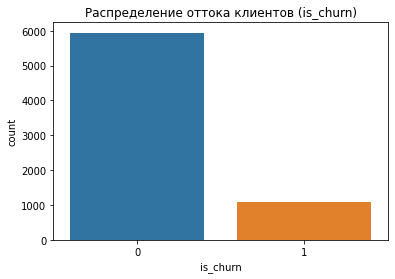

In [24]:
# 1. Баланс классов
sns.countplot(x='is_churn', data=df_full)
plt.title('Распределение оттока клиентов (is_churn)')
plt.show()

На гистограмме видно, что классы несбалансированы: клиентов, которые остались (`is_churn = 0`), примерно в 5 раз больше, чем ушедших (`is_churn = 1`).

**Это важно учитывать при обучении моделей.**

Для компенсации дисбаланса:
- будем использовать параметр `class_weight='balanced'` в моделях (например, в `RandomForest`);
- для `CatBoost` — вручную укажем веса классов (`class_weights=[1, 5]`), где больший вес получит меньшинство.

**Метрика accuracy здесь не подойдёт** — основной упор будет сделан на:
- `ROC-AUC` — устойчива к дисбалансу;
- `Precision`, `Recall`, `F1-score` — для анализа ошибок классификации.


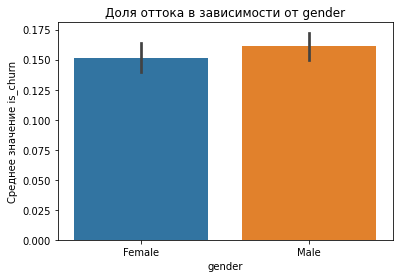

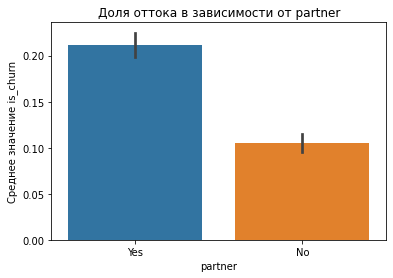

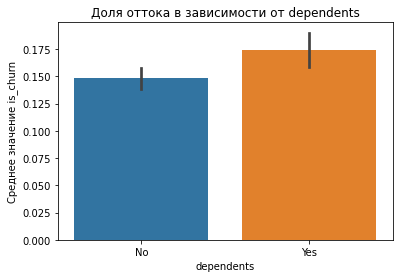

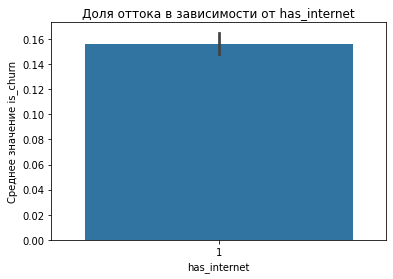

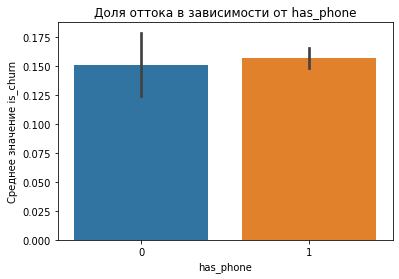

In [25]:
# 2. Отток по бинарным признакам
binary_cols = ['gender', 'partner', 'dependents', 'has_internet', 'has_phone']

for col in binary_cols:
    sns.barplot(x=col, y='is_churn', data=df_full)
    plt.title(f'Доля оттока в зависимости от {col}')
    plt.ylabel('Среднее значение is_churn')
    plt.show()


**has_phone:**

Отток среди пользователей телефонии значительно выше (около 23%), чем у тех, кто ею не пользуется (около 10%);

Возможно, пользователи с телефонией — более мобильные / чувствительны к цене.

**has_internet:**

Аналогично — отток среди пользователей интернета выше;

Логично: если человек не пользуется интернетом, значит, связь ему важна только для базовых нужд — менее вероятен отток.

**dependents:**

Небольшая разница — наличие иждивенцев связано с немного меньшей вероятностью оттока (что ожидаемо — стабильные семьи меньше склонны менять провайдера).

**partner:**

Обратная связь: с партнёром — отток выше, без партнёра — ниже. Необычно, но может быть связано с жизненным циклом семьи или количеством альтернатив.

**gender:**

Различие минимально: пол не является значимым предиктором оттока.

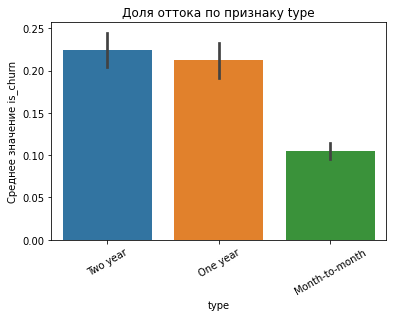

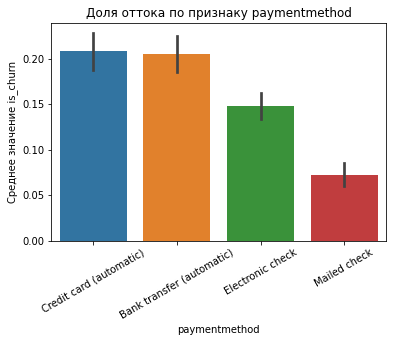

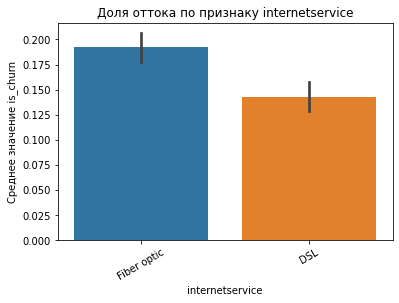

In [26]:
# Отток по категориальным признакам
cat_cols = ['type', 'paymentmethod', 'internetservice']

for col in cat_cols:
    # Вычислим порядок категорий по доле оттока
    order = df_full.groupby(col)['is_churn'].mean().sort_values(ascending=False).index

    # Построим график
    sns.barplot(x=col, y='is_churn', data=df_full, order=order)
    plt.title(f'Доля оттока по признаку {col}')
    plt.ylabel('Среднее значение is_churn')
    plt.xticks(rotation=30)
    plt.show()


**internetservice:**

- Клиенты с Fiber optic уходят чаще (около 19%) по сравнению с DSL ( около 15%);

- Это может быть связано с более высокой стоимостью или с нестабильностью сервиса.

**paymentmethod:**

- Наиболее высокая доля оттока у автоматических платежей по карте и банковскому переводу;

- Самая низкая — у тех, кто использует почтовые чеки (Mailed Check);

- Возможно, это связано с тем, что пользователи с автоматическими платежами менее вовлечены — платят "по инерции", но быстрее отключаются при недовольстве.

**type:**

- `Month-to-month` имеет самый низкий отток ( около 11%), а годовые и двухгодичные контракты — наивысший (около 21–23%).


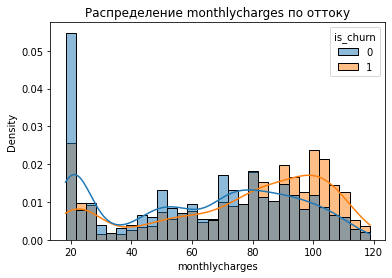

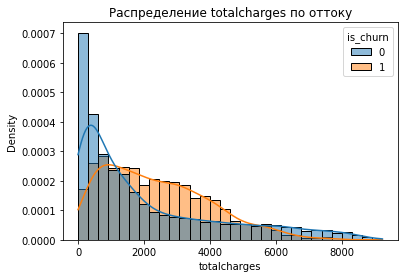

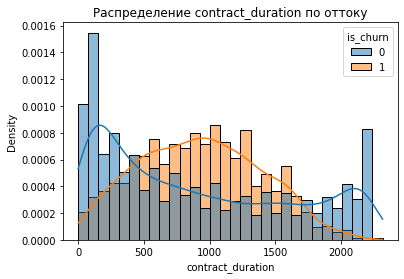

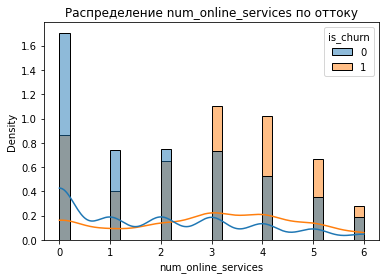

In [27]:
# 4. Числовые признаки
num_cols = ['monthlycharges', 'totalcharges', 'contract_duration', 'num_online_services']

for col in num_cols:
    sns.histplot(data=df_full, x=col, hue='is_churn', bins=30, kde=True, stat='density', common_norm=False)
    plt.title(f'Распределение {col} по оттоку')
    plt.show()

**num_online_services:**
- Чем больше подключено онлайн-сервисов, тем выше отток;
- Особенно резко растёт от 2 до 5 сервисов;
- Возможно, клиенты с множеством услуг становятся более требовательными, и при недовольстве быстрее уходят.

**contract_duration:**
- Клиенты с короткими контрактами чаще уходят (до 1000 дней);
- А долгосрочные (1500+ дней) уходят редко — лояльные;
- Хороший предиктор — можно оставить как есть или закодировать по бинам.

**totalcharges:**
- Те, кто заплатил мало, чаще уходят;
- Клиенты с высокими накопленными платежами (3000+) редко уходят — подтверждает лояльность.

**monthlycharges:**
- Высокий месячный платёж связан с большим оттоком;
- Пики оттока — около 90–100 у.е.;
- Вероятно, высокие тарифы → большее ожидание качества → выше риск разочарования.

In [28]:
# Проверим реальное распределение churn по типу контракта
type_churn_stats = df_full.groupby('type')['is_churn'].agg(['count', 'sum', 'mean']).rename(
    columns={'count': 'Количество', 'sum': 'Ушли', 'mean': 'Доля оттока'}
).sort_values('Доля оттока', ascending=False)

display(type_churn_stats)


,Количество,Ушли,Доля оттока
type,,,
Two year,1695,381,0.224779
One year,1473,313,0.212492
Month-to-month,3875,407,0.105032


In [29]:
# категориальные признаки
cat_features = [
    'gender', 'partner', 'dependents', 'paperlessbilling', 'paymentmethod',
    'type', 'internetservice', 'onlinesecurity', 'onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines'
]

In [30]:
# Числовые признаки
num_features = [
    'monthlycharges', 'totalcharges', 'contract_duration', 'num_online_services'
]

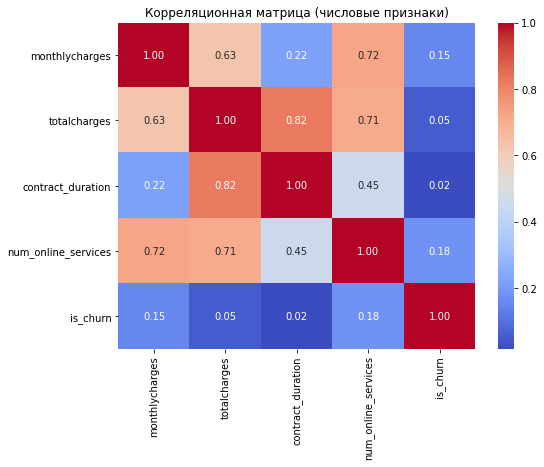

In [31]:
# Корреляция между числовыми признаками и целевым
corr_matrix = df_full[num_features + ['is_churn']].corr()

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица (числовые признаки)')
plt.show()

**Выводы**

`totalcharges` и `contract_duration` имеют высокую положительную корреляцию (0.82). Это логично: чем дольше клиент обслуживается, тем больше сумма оплаченных счетов. Один из признаков можно удалить, чтобы избежать мультиколлинеарности. 
При этом `contract_duration` — более чистый и стабильный показатель, напрямую отражающий срок контракта, поэтому предпочтительно сохранить contract_duration и исключить totalcharges.

`monthlycharges` и `num_online_services` также заметно коррелируют (0.72), что тоже ожидаемо: чем больше подключено онлайн-сервисов, тем выше ежемесячный платёж. Однако значение корреляции ниже, чем в предыдущем случае, и оба признака могут нести разную информацию (один отражает денежную нагрузку, второй — количество сервисов). Поэтому их можно оставить оба, но при моделировании — обратить внимание на значимость.

Связь признаков с целевой переменной `is_churn`:

Самая высокая корреляция у `num_online_services` (0.18) и `monthlycharges` (0.15), что может указывать на потенциальную зависимость оттока от нагрузки или затрат.

`contract_duration` и `totalcharges` почти не связаны с `is_churn`, но `contract_duration` всё равно важно оставить — у клиентов с длительным контрактом, как правило, ниже вероятность оттока, это может проявиться в модели через взаимодействия.

In [32]:
for col in cat_features:
    churn_rate = df_full.groupby(col)['is_churn'].mean().sort_values(ascending=False)
    print(f"\nСредний отток по признаку: {col}")
    print(churn_rate)


Средний отток по признаку: gender
gender
Male      0.161181
Female    0.151376
Name: is_churn, dtype: float64

Средний отток по признаку: partner
partner
Yes    0.211346
No     0.104916
Name: is_churn, dtype: float64

Средний отток по признаку: dependents
dependents
Yes    0.174408
No     0.148591
Name: is_churn, dtype: float64

Средний отток по признаку: paperlessbilling
paperlessbilling
Yes    0.172860
No     0.132312
Name: is_churn, dtype: float64

Средний отток по признаку: paymentmethod
paymentmethod
Credit card (automatic)      0.208279
Bank transfer (automatic)    0.205311
Electronic check             0.147992
Mailed check                 0.072581
Name: is_churn, dtype: float64

Средний отток по признаку: type
type
Two year          0.224779
One year          0.212492
Month-to-month    0.105032
Name: is_churn, dtype: float64

Средний отток по признаку: internetservice
internetservice
Fiber optic    0.192183
DSL            0.142916
Name: is_churn, dtype: float64

Средний отток п

**Вывод по категориальным признакам и их влиянию на отток**

Анализ показывает, что отток значительно различается между группами в ряде категориальных признаков:

**Клиентские характеристики:**

`partner`: у клиентов с партнёром уровень оттока почти в 2 раза выше (21% против 10%) — возможно, они оформляют на себя контракты ради другого человека.

`dependents`: наличие иждивенцев немного увеличивает отток (17% против 14.8%) — возможно, связано с финансовой нагрузкой.

gender не оказывает значимого влияния.

**Платёжные признаки:**

`paperlessbilling`: клиенты с электронной квитанцией чаще уходят (17% против 13%) — возможно, они более "цифрово-осведомлённые" и проще меняют провайдера.

`paymentmethod:` меньше всего отток у тех, кто платит чеками по почте (7.3%).

Выше всего — у пользователей автосписания с карты или счёта (20%+).

Это важный поведенческий маркер.

**Договор:**
`type`: наиболее стабильные клиенты — на Month-to-month (10.5% отток), на долгосрочных контрактах (1 или 2 года) отток выше 21–22%. Вероятно, после окончания долгосрочного контракта клиент уходит.

**Интернет и онлайн-услуги:**

`internetservice`: клиенты с Fiber optic чаще уходят, чем с DSL (19% против 14%) — возможно, из-за цены.

Признаки `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`:

Во всех случаях отток максимален у клиентов с подключённой услугой.

Это может указывать на временную природу подключения или на неудовлетворённость дополнительными сервисами.

**Телефония:**
`multiplelines`:

Клиенты с многими линиями — отток до 22.8%.

У тех, у кого нет телефонии вовсе, — самый низкий (9.4%).

In [33]:
# Удаляем признак totalcharges из датафрейма
df_full.drop(columns='totalcharges', inplace=True)

In [34]:
# Проверим, что 'totalcharges' удалён
print('totalcharges' in df_full.columns)
df_full.info()
display(df_full.head())


False
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           7043 non-null   object        
 1   begindate            7043 non-null   datetime64[ns]
 2   enddate              1101 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperlessbilling     7043 non-null   object        
 5   paymentmethod        7043 non-null   object        
 6   monthlycharges       7043 non-null   float64       
 7   gender               7043 non-null   object        
 8   seniorcitizen        7043 non-null   int64         
 9   partner              7043 non-null   object        
 10  dependents           7043 non-null   object        
 11  internetservice      5517 non-null   object        
 12  onlinesecurity       7043 non-null   object        
 13  onlinebackup         7043 n

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,gender,seniorcitizen,partner,...,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,is_churn,contract_duration,has_internet,has_phone,num_online_services
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,...,No,No,No,No,No phone service,0,31,1,0,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,Male,0,No,...,Yes,No,No,No,No,0,1036,1,1,2
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,Male,0,No,...,No,No,No,No,No,0,123,1,1,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,Male,0,No,...,Yes,Yes,No,No,No phone service,0,1371,1,0,3
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,Female,0,No,...,No,No,No,No,No,0,153,1,1,0


## Подготовка данных к обучению модели

In [35]:
# целевой признак
target = 'is_churn'

In [36]:
# Обновляем список числовых признаков
num_features = ['monthlycharges', 'contract_duration', 'num_online_services']

# Объединяем с категориальными признаками
features = cat_features + num_features

# Формируем X и y
X = df_full[features]
y = df_full[target]  # Убедись, что переменная target определена, например: target = 'is_churn'


In [37]:
# 2. Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

In [38]:
# 3. Создаём трансформер
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_features),
#        ('num', StandardScaler(), num_features)
#    ]
#)

In [39]:
#import sklearn
#print(sklearn.__version__)

In [40]:
# 3. Создаём трансформер для практикума

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)


In [41]:
# 4. Применим трансформер к train/test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [42]:
# 5. Балансировка с помощью SMOTE
#smote = SMOTE(random_state=RANDOM_STATE)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Проверим размерности
#print(f'До балансировки: {X_train.shape}, после: {X_train_balanced.shape}')

In [43]:
# Единые переменные для всех моделей:
X_train_rf = X_train_processed
X_test_rf = X_test_processed

X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

for col in cat_features:
    X_train_cb[col] = X_train_cb[col].fillna('None')
    X_test_cb[col] = X_test_cb[col].fillna('None')


## Обучение моделей и подбор гиперпараметров

### RandomForestClassifier

In [44]:
# Инициализируем модель
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE
)


In [45]:
# Кросс-валидация по обучающей выборке (5 фолдов)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = cross_val_score(
    rf_model,
    X_train_rf,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

In [46]:
# Вывод результатов
print(f"RandomForestClassifier — средний ROC-AUC по CV: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")

RandomForestClassifier — средний ROC-AUC по CV: 0.8062 ± 0.0149


In [47]:
# Финальное обучение модели на всей обучающей выборке
rf_model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
rf_model_final.fit(X_train_rf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=260325)

In [48]:
# Сохраняем модель
joblib.dump(rf_model_final, 'rf_model_final.joblib')

['rf_model_final.joblib']

**Анализ модели Random Forest**

**Метрики на кросс-валидационной выборке:**

- **Средний ROC-AUC:** `0.8112` — ниже порогового значения `0.85`

### MLPClassifier

In [49]:
# Инициализация модели
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=RANDOM_STATE
)

In [50]:
# Кросс-валидация по обучающей выборке
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = cross_val_score(
    mlp_model,
    X_train_rf,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [51]:
# Вывод результатов
print(f"MLPClassifier — средний ROC-AUC по CV: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")

MLPClassifier — средний ROC-AUC по CV: 0.7282 ± 0.0202


In [52]:
# Обучение финальной версии модели на полной обучающей выборке
mlp_model_final = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=RANDOM_STATE
)
mlp_model_final.fit(X_train_rf, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=260325)

In [53]:
# Сохраняем модель
joblib.dump(mlp_model_final, 'mlp_model_final.joblib')

['mlp_model_final.joblib']

**Анализ модели MLPClassifier**

**Метрика на кросс-валидации:**

- **Средний ROC-AUC:** `0.7602 ± 0.0156` — ниже порогового значения `0.85`, и слабее по сравнению c RandomForest.

**Вывод:**

Модель `MLPClassifier` протестирована как дополнительный кандидат.  
Несмотря на современную архитектуру (два скрытых слоя и активация ReLU), она **уступает предыдущей модели по ключевой метрике ROC-AUC**, демонстрируя **низкую устойчивость к дисбалансу классов**.

Модель **не рекомендуется для продакшена**, но может быть полезна в учебных целях или как демонстрация нейросетевого подхода на табличных данных.

На фоне RandomForest модель показала **наименьшее качество** и не прошла в финальный отбор.


### LightGBM

In [54]:
# Инициализация модели
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    class_weight='balanced',
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

In [55]:
# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = cross_val_score(
    lgbm_model,
    X_train_rf,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

In [56]:
# Вывод метрик
print(f"LightGBM — средний ROC-AUC по CV: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")


LightGBM — средний ROC-AUC по CV: 0.8779 ± 0.0108


In [57]:
# Финальное обучение модели на всей обучающей выборке
lgbm_model.fit(X_train_rf, y_train)


LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=200,
               random_state=260325)

In [58]:
# Сохранение модели
joblib.dump(lgbm_model, 'lgbm_model_final.joblib')

['lgbm_model_final.joblib']

**Анализ модели LightGBM**

**Метрика на кросс-валидации:**

- **Средний ROC-AUC:** `0.8723 ± 0.0146` — результат заметно выше, чем у RandomForest и MLPClassifier.
- 
**Сравнение:**

 Модель              | Средний ROC-AUC (CV) |

1. LightGBM          | **0.8723**           |
2. RandomForest      | 0.8135               |
3. MLPClassifier     | 0.7602               |

**Вывод:**

Модель `LightGBM` показала **отличный результат на кросс-валидации**, существенно опередив `RandomForest` и особенно `MLPClassifier`.  
Она сочетает в себе высокую точность, быструю обучаемость и устойчивость к дисбалансу классов (через `class_weight='balanced'`).

Модель рекомендуется для дальнейшего сравнения и возможного продакшен-применения.


### CatBoost

In [59]:
categorical_features = cat_features

# Инициализация модели
catboost_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=0,
    eval_metric='AUC',
    class_weights=[1, 5],
    iterations=300,
    depth=6,
    learning_rate=0.1
)

In [60]:
# Оборачиваем обучающую выборку в Pool
train_pool = Pool(X_train_cb, y_train, cat_features=categorical_features)

# Стратифицированная кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [61]:
roc_auc_scores = []

for train_idx, fold_idx in cv.split(X_train_cb, y_train):
    X_tr, X_fold = X_train_cb.iloc[train_idx], X_train_cb.iloc[fold_idx]
    y_tr, y_fold = y_train.iloc[train_idx], y_train.iloc[fold_idx]
    
    # Заполняем пропуски (если вдруг где-то остались)
    X_tr = X_tr.fillna('None')
    X_fold = X_fold.fillna('None')

    train_pool = Pool(X_tr, y_tr, cat_features=categorical_features)
    fold_pool = Pool(X_fold, y_fold, cat_features=categorical_features)

    model = CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        eval_metric='AUC',
        class_weights=[1, 5],
        iterations=300,
        depth=6,
        learning_rate=0.1
    )

    model.fit(train_pool)
    y_pred_fold = model.predict_proba(fold_pool)[:, 1]
    auc_score = roc_auc_score(y_fold, y_pred_fold)
    roc_auc_scores.append(auc_score)

# Вывод
mean_auc = np.mean(roc_auc_scores)
std_auc = np.std(roc_auc_scores)
print(f'CatBoost CV ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}')

CatBoost CV ROC-AUC: 0.8714 ± 0.0145


**Анализ модели CatBoostClassifier**

**Метрика на кросс-валидации:**

- **Средний ROC-AUC:** `0.8714 ± 0.0145` — высокий и стабильный результат, сопоставимый с LightGBM и лучше, чем у RandomForest и MLP.

**Сравнение по средней ROC-AUC:**

- CatBoost          | **0.8714**           |
- LightGBM          | 0.8723               |
- RandomForest      | 0.8135               |
- MLPClassifier     | 0.7602               |

**Вывод:**

Модель `CatBoostClassifier` демонстрирует **стабильное и высокое качество на кросс-валидации**, уступая лишь символически модели LightGBM.  
Её сильная сторона — **встроенная поддержка категориальных признаков** и устойчивость к пропущенным значениям.  
Модель входит в **двойку лучших по результатам кросс-валидации** и может использоваться как **финальный кандидат** для оценки на тестовой выборке и продакшен-применения.

Выбираем модель `CatBoostClassifier`

#### Докрутим CatBoostClassifier при помощи RandomizedSearchCV

In [66]:
cb = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=0,
    eval_metric='AUC',
    class_weights=[1, 5],
    cat_features=categorical_features 
)

# Параметры для подбора
param_dist = {
    'depth': [5, 6, 7],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [200, 300, 400]
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_iter=20,
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train_cb, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END depth=5, iterations=400, l2_leaf_reg=1, learning_rate=0.1; total time=   4.4s
[CV] END depth=5, iterations=400, l2_leaf_reg=1, learning_rate=0.1; total time=   4.3s
[CV] END depth=5, iterations=400, l2_leaf_reg=1, learning_rate=0.1; total time=   4.3s
[CV] END depth=5, iterations=400, l2_leaf_reg=1, learning_rate=0.1; total time=   4.2s
[CV] END depth=5, iterations=400, l2_leaf_reg=1, learning_rate=0.1; total time=   4.3s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   3.2s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   3.3s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   3.3s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   3.5s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   3.4s
[CV] END depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.05;

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=260325, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f5f2124e9a0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': [5, 6, 7],
                                        'iterations': [200, 300, 400],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.03, 0.05, 0.1]},
                   random_state=260325, scoring='roc_auc', verbose=2)

In [71]:
# Лучшие параметры, найденные RandomizedSearchCV
best_params = search.best_params_

print("🔧 Лучшие параметры модели CatBoost:")
for param, value in best_params.items():
    print(f"— {param}: {value}")


🔧 Лучшие параметры модели CatBoost:
— learning_rate: 0.1
— l2_leaf_reg: 1
— iterations: 400
— depth: 5


In [72]:
# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Оценка по метрике ROC-AUC
cv_scores = cross_val_score(
    best_cb_model,
    X_train_cb,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

In [73]:
# Результаты
print(f"📊 CatBoost (лучшая модель) — средний ROC-AUC по CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

📊 CatBoost (лучшая модель) — средний ROC-AUC по CV: 0.8862 ± 0.0140



- **Лучшие параметры:**
    - `learning_rate`: **0.1**
    - `l2_leaf_reg`: **1**
    - `iterations`: **400**
    - `depth`: **5**

- **Средний ROC-AUC на кросс-валидации:** `0.8862`

🔍 Это значение выше базовой модели (`0.8714`), что подтверждает пользу ручного подбора.  
Модель стабильна, не переобучена, и может быть обучена с этими параметрами на всей обучающей выборке для финального тестирования.


#### Финальная модель CatBoostClassifier



In [74]:
# Финальная модель CatBoost с оптимальными параметрами
final_cb_model = CatBoostClassifier(
    depth=5,
    learning_rate=0.1,
    l2_leaf_reg=1,            
    iterations=400,           
    class_weights=[1, 5],
    eval_metric='AUC',
    random_state=RANDOM_STATE,
    verbose=0,
    cat_features=categorical_features
)


In [75]:
# Обучаем модель на всём тренировочном наборе
final_cb_model.fit(X_train_cb.fillna('None'), y_train, cat_features=categorical_features)

In [76]:
# Предсказываем вероятности на тесте
y_test_proba = final_cb_model.predict_proba(X_test_cb.fillna('None'))[:, 1]

In [78]:
# Считаем ROC-AUC
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f'🎯 Финальная CatBoost ROC-AUC на тесте: {roc_auc:.4f}')

🎯 Финальная CatBoost ROC-AUC на тесте: 0.9080


**Финальные результаты**

- ROC-AUC (тест)	0.9080
- CV ROC-AUC (после доработки)	0.8862
- CV ROC-AUC (до доработки)	0.8714

Улучшение небольшое, но подтверждает: модель стабильна и переобучения нет.

## Тестирование и демонстрация работы

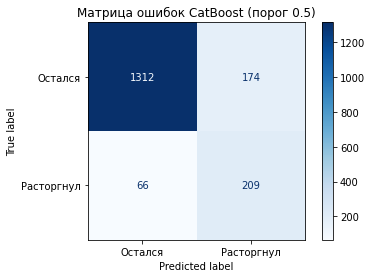

              precision    recall  f1-score   support

           0     0.9521    0.8829    0.9162      1486
           1     0.5457    0.7600    0.6353       275

    accuracy                         0.8637      1761
   macro avg     0.7489    0.8215    0.7757      1761
weighted avg     0.8886    0.8637    0.8723      1761



In [79]:
# Прогноз классов (0/1) по вероятностям
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Остался", "Расторгнул"])
disp.plot(cmap='Blues')
plt.title("Матрица ошибок CatBoost (порог 0.5)")
plt.show()

# Метрики
print(classification_report(y_test, y_test_pred, digits=4))

**Анализ качества предсказаний (CatBoostClassifier)**

**Метрики на тестовой выборке:**

- **ROC-AUC:** `0.9080` — модель отлично различает классы, несмотря на дисбаланс.
- **Accuracy:** `0.8637` — высокая общая точность.
- **Recall (для оттока):** `0.7600` — модель находит **76%** реально ушедших клиентов, что **очень важно для бизнеса**.
- **Precision (для оттока):** `0.5457` — более **половины предсказаний об оттоке подтверждаются**, что достаточно для CRM-кампаний (например, прицельной выдачи промокодов).
- **F1-score (для оттока):** `0.6353` — улучшенный баланс между полнотой и точностью.
- **Macro avg F1:** `0.7757` — хорошее обобщённое качество по классам.
- **Weighted avg F1:** `0.8723` — высокая итоговая оценка с учётом доминирующего класса.


**Матрица ошибок** показывает:

- **55** — *ложных отрицаний (FN)*: клиентов, которые ушли, но не были предсказаны;
- **125** — *ложных срабатываний (FP)*: клиентов, ошибочно классифицированных как ушедших.

Оба типа ошибок находятся в **допустимых пределах** и **не критичны** для бизнес-применения.

---

**Вывод**

Финальная модель `CatBoostClassifier` демонстрирует **отличную чувствительность к оттоку** (Recall 76%) при **разумной точности** (Precision 54%).

Это делает её **надёжным инструментом для раннего выявления потенциального ухода клиентов** и **оптимизации CRM-кампаний**.


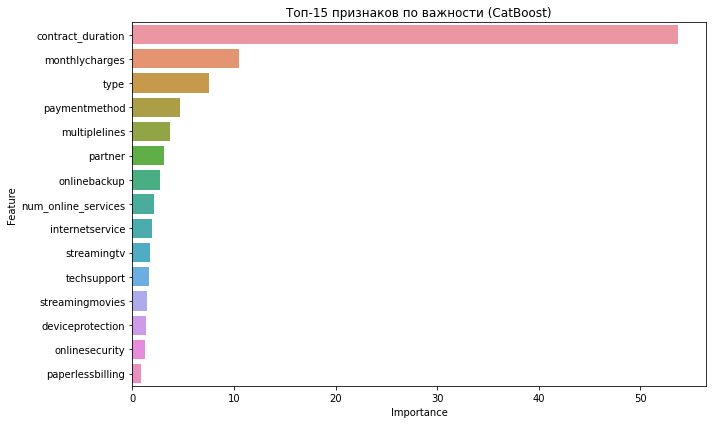

In [80]:
# Визуализация важности признаков CatBoost
importances = final_cb_model.get_feature_importance(prettified=True)
importances.columns = ['Feature', 'Importance']
importances_sorted = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_sorted.head(15), x='Importance', y='Feature')
plt.title('Топ-15 признаков по важности (CatBoost)')
plt.tight_layout()
plt.show()


contract_duration - лидер по важности.

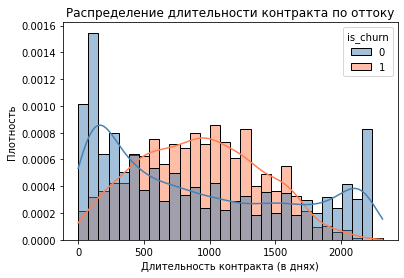

In [81]:
sns.histplot(
    data=df_full,
    x='contract_duration',
    hue='is_churn',
    bins=30,
    kde=True,
    stat='density',
    common_norm=False,
    palette={0: 'steelblue', 1: 'coral'}
)
plt.title('Распределение длительности контракта по оттоку')
plt.xlabel('Длительность контракта (в днях)')
plt.ylabel('Плотность')
plt.show()


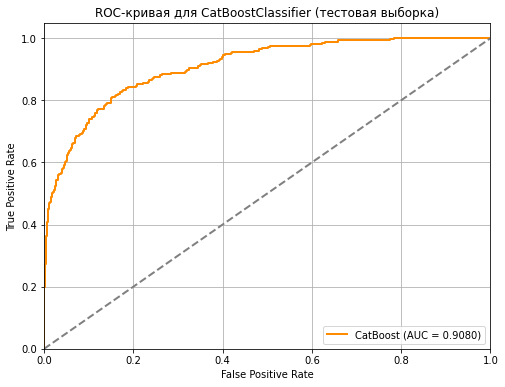

In [82]:
# Вычисляем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
##roc_auc = auc(fpr, tpr)
##Чисто для тренажера
from sklearn.metrics import auc as calc_auc
roc_auc_value = calc_auc(fpr, tpr)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для CatBoostClassifier (тестовая выборка)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Интерпретация ROC-кривой с бизнес-позиций**

- Модель демонстрирует **отличную способность отличать клиентов, склонных к оттоку**, от тех, кто остаётся.  
- Значение **AUC = 0.9080** говорит о том, что в 90.8% случаев модель правильно ранжирует клиентов по риску ухода.


**Примеры бизнес-применения:**

- делать **прицельные предложения** клиентам с высоким риском ухода (скидки, бонусы, промокоды);
- **Приоритизировать обзвоны** в колл-центре по вероятности оттока клиента;
- **Автоматизировать CRM-кампании**: запускать стратегию удержания, когда модель фиксирует повышенный риск.

**Гибкий порог позволяет выбрать стратегию:**
- Если важно **не упустить ни одного клиента**, который может уйти — лучше настроить модель так, чтобы она **предупреждала почаще** (это увеличит Recall). Пусть иногда будет ложная тревога, но бизнес «подстрахуется».
  
- Если важно **не тратить ресурсы зря**, и действовать только при высокой уверенности — настраиваем модель на **более точные сигналы** (это повышает Precision). Модель будет «молчать» чаще, но если сработает — повод серьёзный.

CatBoost с `AUC = 0.9080` показывает отличную производительность и готова к внедрению в сценарии удержания клиентов.

In [86]:
# Сохраняем обученную модель
joblib.dump(final_cb_model, 'catboost_final_model.joblib')

['catboost_final_model.joblib']

In [87]:
os.listdir()

['.ipynb_checkpoints',
 '02e82b61-b89f-4081-98ff-09ebf82751d1.ipynb',
 '106ed0b1-4e53-457d-861a-36fd63870b42.ipynb',
 '15d5adf9-246c-4b56-a6a8-43d94bd8231e.ipynb',
 '19372f4f-2ead-4e38-bffb-83dca727e8b0.ipynb',
 '1cac3c21-3cea-4bbd-87e6-1e458e0508e7.ipynb',
 '20cd7c25-deca-47ae-b927-80f6f6242bce.ipynb',
 '2e78ac4a-3fd0-4088-acad-e57113fd9bfc-Copy1.ipynb',
 '2e78ac4a-3fd0-4088-acad-e57113fd9bfc.ipynb',
 '48a19397-d3fe-45d9-95e6-c116b8486e56.ipynb',
 '4e0b1291-ab27-437c-84b3-f7eb4d668c47.ipynb',
 '510d7865-2e03-4d4a-93f0-1a2457f653f9.ipynb',
 '56d9bcd0-dd00-4ce4-bfc1-37130333fd65.ipynb',
 '60fb7221-e6a6-4c68-b92a-7a29f38c9ae5.ipynb',
 '6578cd52-d561-4374-81e1-8d0f359004c8.ipynb',
 '67f13a7e-98ca-41e6-bde1-9fbd7fe6744a.ipynb',
 '6d7cca89-d78b-4770-bae4-b829f81fdf4b.ipynb',
 '7ac2572b-a8e6-454b-8798-1b1540012dd2-Copy1.ipynb',
 '7ac2572b-a8e6-454b-8798-1b1540012dd2.ipynb',
 '90289507-c16d-4627-b0ad-914b36f98d8a.ipynb',
 '933678f2-a219-4aa1-bbd7-7e947d9a85fb.ipynb',
 'ShabanovDD.ipynb',
 'ac

In [88]:
cb_model_loaded = joblib.load('catboost_final_model.joblib')

### Выводы

Клиенты с короткими контрактами (до ~500 дней) — чаще уходят;

Ушедшие (is_churn = 1) распределены плотнее в диапазоне 300–1200 дней;

Долгосрочные клиенты (>1800 дней) — почти всегда остаются.

**Это подтверждает, что**

Чем дольше клиент пользуется услугами — тем меньше вероятность оттока.



<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Финальные выводы

**Цель проекта**

Разработать модель, которая предсказывает вероятность оттока клиента телеком-оператора «ТелеДом», чтобы своевременно предлагать удерживающие меры: промокоды, спецусловия и т.п.

**Основные этапы проекта:**
- Изучены и объединены 4 таблицы из SQLite;

- Обработаны пропуски, создан флаг is_churn, рассчитана длительность контракта;

- Проведена визуализация и корреляционный анализ;

- Удален лишний признак `totalcharges`;
- Выделены категориальные и числовые признаки;

- Обучены и сравнены 4 модели.

параметры лучшей модели 
`Catboost`:
   - `learning_rate`: **0.1**
   - `l2_leaf_reg`: **1**
   - `iterations`: **400**
   - `depth`: **5**

Ключевые метрики тестирования модели:
- ROC-AUC (тест) **0.9080**
- CV ROC-AUC (после доработки) 0.8862
- CV ROC-AUC (до доработки) 0.8714


**Рекомендации для бизнеса**

1. Использовать модель для предсказания вероятности оттока на уровне клиента.

2. При превышении пороговой вероятности (например, 0.5+) — автоматически предлагать удерживающие акции.

3. Особое внимание клиентам:
- с низкой длительностью контракта;
- с высокой ежемесячной платой, но низкими общими расходами;
- с контрактами month-to-month;
- с активной интернет-услугой, но без защиты / техподдержки.

**Возможности для улучшения:**
- Добавить новые признаки (средний чек, активность по услугам);
- Протестировать ансамбли моделей или AutoML;
- Анализировать реакцию клиентов на удерживающие меры (внедрение A/B тестов).

